In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from fluidvec import *

In [4]:
import torch
import pickle
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
from fluidvec import create_fluid_keyvec, VocabSet
# torch.autograd.set_detect_anomaly(True)

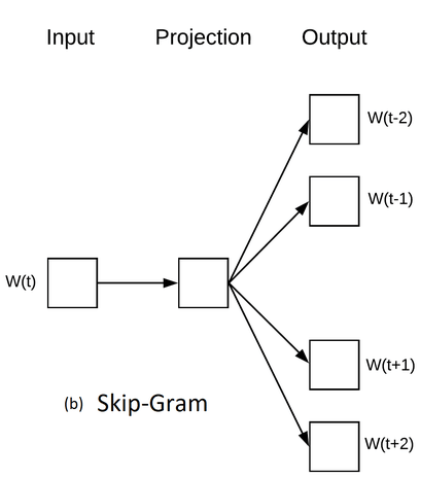

## FastText model
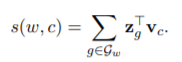
* $s(w, c)$: score between a target word and its context word
* $\mathcal{G}_w$: the ngrams in the target word
* $\mathbf{z}_g$: the vector representation of each ngram
* $\mathbf{v}_c$: the vector representation of the context


In [5]:
vs = VocabSet.load()
wvocab = vs.word_vocab

In [6]:
fkv = create_fluid_keyvec("../data/model/fluidvec-char.b.1")
fkv

device:  cpu
n_neg_sample:  5


<FluidKeyedVectors: 217350 words, 20396 chars, 100 dimensions>

In [7]:
fkv.vectors.shape

(237746, 100)

In [8]:
fkv.most_similar("社會")

[('價值觀', 0.7773041129112244),
 ('官場', 0.7543519139289856),
 ('法治', 0.7478264570236206),
 ('政治', 0.7471389174461365),
 ('常民', 0.7431472539901733),
 ('場域', 0.7417535781860352),
 ('惡質', 0.7380431294441223),
 ('弊病', 0.737770676612854),
 ('不平等', 0.737763524055481),
 ('女權', 0.73651123046875)]

In [11]:
fkv.most_similar("/人/", topn=10, word_only=True)

[('令', 0.14281512796878815, 3773),
 ('', 0.12988783419132233, 75),
 ('兩', 0.10173933953046799, 17530),
 ('目不暇給', 0.08045397698879242, 45),
 ('鼻酸', 0.07669729739427567, 26),
 ('誤以為', 0.07587025314569473, 108),
 ('有', 0.07276242226362228, 81794),
 ('很多', 0.07268070429563522, 4418),
 ('印象深刻', 0.07110641896724701, 61),
 ('信服', 0.06657253950834274, 49)]

In [66]:
fkv.similarity("老師", ".師/")

-0.10699998

In [15]:
[(t, s) for t, s in fkv.most_similar([fkv.get_vec_from_chars(["/社.", ".會.", ".學.", ".家/"])], topn=10)]

[('/社.', 0.8769491314888),
 ('.家/', 0.8641639351844788),
 ('/人.', 0.8620777726173401),
 ('/教.', 0.8483855128288269),
 ('.識/', 0.8464498519897461),
 ('.界/', 0.8460058569908142),
 ('/學.', 0.844926118850708),
 ('.學.', 0.8402619361877441),
 ('/理.', 0.8353738188743591),
 ('.導/', 0.8332624435424805)]

In [77]:
a = torch.tensor([[2,2,2,2], [3,3,3,3]]).reshape(2, 4)
b = torch.arange(24).reshape(2, 3, 4)

In [101]:
norms = np.linalg.norm(word_vecs, axis=1)
norm_vecs = word_vecs / norms[..., np.newaxis]

array([1.        , 1.        , 1.        , ..., 1.        , 0.99999994,
       1.        ], dtype=float32)

(array([ 3180.,  6750.,  2728., 42002.,   144.,   135.,  6120., 86235.,
        68737.,  1319.]),
 array([ 4.369518 ,  5.9981785,  7.6268387,  9.255499 , 10.884159 ,
        12.51282  , 14.14148  , 15.770141 , 17.398802 , 19.027462 ,
        20.656122 ], dtype=float32),
 <a list of 10 Patch objects>)

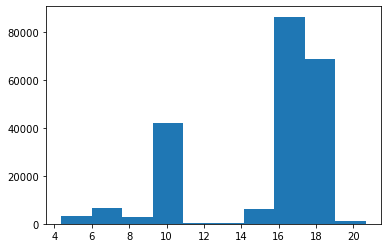

In [91]:
import matplotlib.pyplot as plt
plt.hist(norms)

In [9]:
kv.add_vectors(words, word_vecs)
if hypers["n_char"]:
    assert len(chars) == char_vecs.shape[0]
    kv.add_vectors(chars, char_vecs)
if hypers["n_compo"]:
    assert len(compos) == compo_vecs.shape[0]
    kv.add_vectors(compos, compo_vecs)

In [10]:
import pickle
with open("../data/word_mappings.pkl", "rb") as fin:
    word_mappings = pickle.load(fin)
word_mappings.update({
    "<UNK>": {'compos': [0], 'chars': [0], 'word': 0},
    "<PAD>": {'compos': [1], 'chars': [1], 'word': 1}
})

In [11]:
kv.most_similar("電腦")

[('設備', 0.9537464380264282),
 ('硬體', 0.9529376029968262),
 ('主機', 0.9517901539802551),
 ('應用', 0.9511823654174805),
 ('軟件', 0.9496055841445923),
 ('裝置', 0.9487616419792175),
 ('技術', 0.9484235644340515),
 ('電算', 0.9476643800735474),
 ('程式', 0.9476211667060852),
 ('網路', 0.9466950297355652)]

In [20]:
kv.most_similar(["_名", "補", "教", "師_"])

[('，', 0.7604602575302124),
 ('替', 0.7590786218643188),
 ('由', 0.7586535215377808),
 ('名', 0.7579584121704102),
 ('校', 0.7567354440689087),
 ('取', 0.7565784454345703),
 ('及', 0.7563090920448303),
 ('聘', 0.7559428215026855),
 ('除', 0.755350649356842),
 ('是', 0.7553378939628601)]

In [13]:
kv.most_similar("人")

[('，', 0.9773836731910706),
 ('的', 0.9739871621131897),
 ('者', 0.9724314212799072),
 ('他', 0.972251832485199),
 ('有', 0.9722487926483154),
 ('及', 0.971566379070282),
 ('也', 0.9714357852935791),
 ('和', 0.9709134101867676),
 ('而', 0.9708647131919861),
 ('在', 0.9707973599433899)]

In [42]:
freq_w = sorted([(k,v) for k, v in new_vs.word_vocab.freq.items()], key=lambda x: -new_vs.word_vocab.freq.get(x[0]))[100:110]

In [44]:
[new_vs.word_vocab.decode(x[0]) for x in freq_w]

['社會', '可能', '新', '工作', '公司', '如果', '用', '目前', '小', '家']

In [13]:
kv.most_similar(["_社", "會_"])

[('_，_', 0.5307013392448425),
 ('_的_', 0.5286708474159241),
 ('界_', 0.5093251466751099),
 ('_政', 0.5017181634902954),
 ('_與_', 0.49974486231803894),
 ('_關', 0.4947202205657959),
 ('制_', 0.4930032193660736),
 ('象_', 0.4926375448703766),
 ('言_', 0.4925975799560547),
 ('_情', 0.4876929521560669)]

In [14]:
kv.most_similar(["_公", "司_"])

[('業_', 0.5404669046401978),
 ('資_', 0.527643084526062),
 ('_將_', 0.5105589628219604),
 ('_電', 0.5070722103118896),
 ('_華', 0.5022088289260864),
 ('款_', 0.4920397698879242),
 ('_與_', 0.4849219024181366),
 ('_中', 0.483971506357193),
 ('_在_', 0.48190173506736755),
 ('_成', 0.47708362340927124)]

In [15]:
kv.most_similar(["_硬", "體_"])

[('_將_', 0.5380154252052307),
 ('_相', 0.5167953968048096),
 ('_生', 0.5152868032455444),
 ('_環', 0.5131213665008545),
 ('端_', 0.5104857683181763),
 ('_光', 0.5079119205474854),
 ('性_', 0.506935715675354),
 ('題_', 0.5006105899810791),
 ('_功', 0.4934723973274231),
 ('器_', 0.4931347072124481)]

In [13]:
def make_model_input(word):
    item = {k: v for k, v in word_mappings[word].items()}
    item["compos"] = [new_vs.compo_vocab.decode(x) for x in item["compos"]]
    item["chars"] = [new_vs.char_vocab.decode(x) for x in item["chars"]]    
    return item["chars"] + item["compos"]

In [31]:
make_model_input("人物")

['_人', '物_', '<COMPO_NA>', '⿰0-牛', '⿰1-勿']

In [30]:
kv.most_similar(["_人", "設_"])

[('_也_', 0.2797718942165375),
 ('_在_', 0.272450715303421),
 ('_，_', 0.2661602199077606),
 ('_為_', 0.25626084208488464),
 ('紀伯倫', 0.24607113003730774),
 ('對_', 0.2428818941116333),
 ('_及_', 0.2286974936723709),
 ('法管學院', 0.22854962944984436),
 ('安佛羅西', 0.22707603871822357),
 ('廣告法', 0.2257523536682129)]